In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d crawford/emnist

Dataset URL: https://www.kaggle.com/datasets/crawford/emnist
License(s): CC0-1.0
 98% 1.22G/1.24G [00:21<00:00, 67.7MB/s]
100% 1.24G/1.24G [00:21<00:00, 62.8MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/emnist.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import pandas as pd
import numpy as np
import os
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout
import cv2

In [ ]:
# Function to convert CSV to png images
def csv_to_images(csv_path, output_dir):
    df = pd.read_csv(csv_path,header=None)
    for index, row in df.iterrows():
        label = str(row[0])  # Ensure 'class' is the correct column name
        image_array = np.array(row[1:], dtype=np.uint8).reshape(28, 28)  # Adjust according to actual image size
        label_dir = os.path.join(output_dir, label)
        os.makedirs(label_dir, exist_ok=True)
        image = Image.fromarray(image_array)
        image.save(os.path.join(label_dir, f'{index}.png'))

# Convert train and test CSVs to images
csv_to_images('/content/emnist-balanced-train.csv', '/content/emnist-letters-train-images')
csv_to_images('/content/emnist-balanced-test.csv', '/content/emnist-letters-test-images')

In [ ]:
#generators
train_ds = keras.utils.image_dataset_from_directory(
    directory ='/content/emnist-letters-train-images',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(28,28),
    color_mode='grayscale'
)
validation_ds=keras.utils.image_dataset_from_directory(
    directory ='/content/emnist-letters-test-images',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(28,28),
    color_mode='grayscale'
)

Found 112800 files belonging to 47 classes.
Found 18800 files belonging to 47 classes.


In [ ]:
#Normalize
def process(image,label):
  image=tf.cast(image ,tf.float32)/ 255.0
  return image, label

train_ds = train_ds.map(process)
validation_ds= validation_ds.map(process)



In [ ]:
#create CNN model

model = Sequential()

# First convolutional layer
model.add(Conv2D(32, kernel_size=(3, 3),padding='valid', activation='relu', input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=2,padding='valid'))

# Second convolutional layer
model.add(Conv2D(64, kernel_size=(3, 3),padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=2,padding='valid'))

# Third convolutional layer
model.add(Conv2D(128, kernel_size=(3, 3),padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=2,padding='valid'))


model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(47, activation='softmax'))


In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
history= model.fit(train_ds, epochs=10, validation_data=validation_ds)

Epoch 1/10
3525/3525 [==============================] - 257s 72ms/step - loss: 0.8185 - accuracy: 0.7372 - val_loss: 0.5238 - val_accuracy: 0.8216
Epoch 2/10
3525/3525 [==============================] - 243s 69ms/step - loss: 0.5181 - accuracy: 0.8211 - val_loss: 0.4704 - val_accuracy: 0.8365
Epoch 3/10
3525/3525 [==============================] - 249s 71ms/step - loss: 0.4610 - accuracy: 0.8375 - val_loss: 0.4762 - val_accuracy: 0.8353
Epoch 4/10
3525/3525 [==============================] - 234s 66ms/step - loss: 0.4231 - accuracy: 0.8481 - val_loss: 0.4503 - val_accuracy: 0.8463
Epoch 5/10
3525/3525 [==============================] - 248s 70ms/step - loss: 0.3996 - accuracy: 0.8550 - val_loss: 0.4480 - val_accuracy: 0.8453
Epoch 6/10
3525/3525 [==============================] - 235s 67ms/step - loss: 0.3784 - accuracy: 0.8610 - val_loss: 0.4469 - val_accuracy: 0.8495
Epoch 7/10
3525/3525 [==============================] - 240s 68ms/step - loss: 0.3607 - accuracy: 0.8665 - val_loss: 0

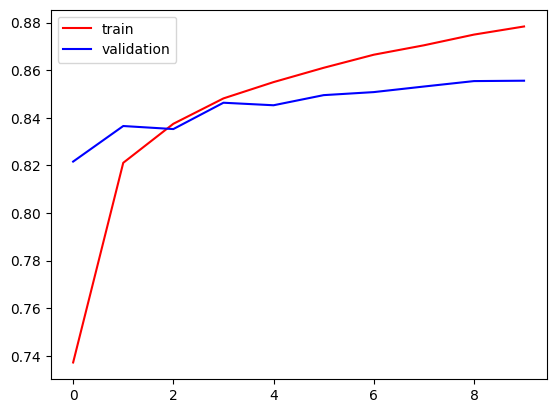

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], color='red', label='train')
plt.plot(history.history['val_accuracy'], color='blue', label='validation')
plt.legend()
plt.show()

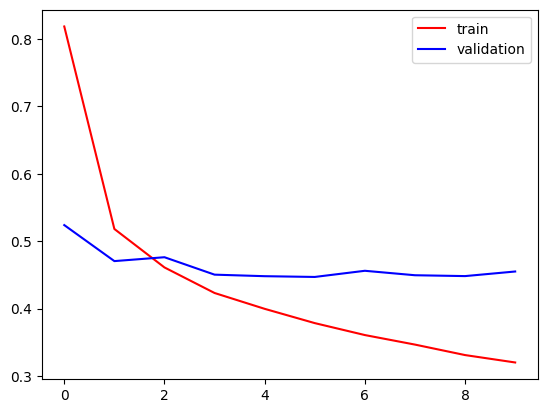

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], color='red', label='train')
plt.plot(history.history['val_loss'], color='blue', label='validation')
plt.legend()
plt.show()

In [ ]:
test_img = cv2.imread('/content/Screenshot 2024-07-12 192508.png', cv2.IMREAD_UNCHANGED)  # Convert to grayscale
if test_img.shape[-1] == 4:
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGRA2BGR)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
if len(test_img.shape) == 3:  # Check if the image is not grayscale
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)

In [ ]:
test_img = cv2.resize(test_img, (28, 28))
test_img = test_img.astype('float32') / 255.0
test_input = test_img.reshape((1, 28, 28, 1))  # Reshape for grayscale input

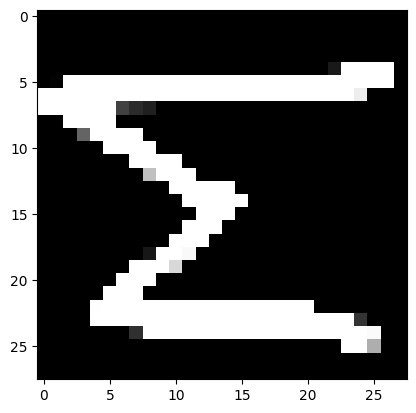

In [ ]:
plt.imshow(test_input.reshape(28, 28), cmap='gray')
plt.show()

In [ ]:
predictions = model.predict(test_input)
predicted_class_index = np.argmax(predictions)
index_to_class_label = {
   0: '0', 1: '1', 2: 'A', 3: 'B', 4: 'C', 5: 'D', 6: 'E', 7: 'F', 8: 'G', 9: 'H',
    10: 'I', 11: 'J', 12: '2', 13: 'K', 14: 'L', 15: 'M', 16: 'N', 17: 'O', 18: 'P', 19: 'Q',
    20: 'R', 21: 'S', 22: 'T', 23: '3', 24: 'U', 25: 'V', 26: 'W', 27: 'X', 28: 'Y', 29: 'Z',
    30: 'a', 31: 'b', 32: 'd', 33: 'e', 34: '4', 35: 'f', 36: 'g', 37: 'h', 38: 'n', 39: 'q',
    40: 'r', 41: 't', 42: '5', 43: '6', 44: '7', 45: '8', 46: '9'
}
predicted_class_label = index_to_class_label[predicted_class_index]
print(f'The predicted class index is: {predicted_class_index}')
print(f'The predicted class label is: {predicted_class_label}')

1/1 [==============================] - 0s 355ms/step
The predicted class index is: 15
The predicted class label is: M
